In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [58]:
df = pd.read_csv("insurance.csv")

# lets predict if a student will pass or fail based on the other columns

In [59]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94


In [60]:
df.describe()

# lets check value counts of the columns and replace the values with 1 and 0 to simplify the model

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [61]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [62]:
df.duplicated().sum()

1

In [63]:
df.drop_duplicates(inplace=True)

In [64]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [65]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [66]:
df['sex'].replace(['female'], 0, inplace=True)
df['sex'].replace(['male'], 1, inplace=True)

df['smoker'].replace(['no'], 0, inplace=True)
df['smoker'].replace(['yes'], 1, inplace=True)

In [67]:
variables = ['region']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

# splited regions into columns

In [68]:
# min - 1121
# max - 63770

def map_number_to_category(charges):
    if 1000 <= charges < 12000:
        return 'low'
    elif 12000 <= charges < 30000:
        return 'avg'
    elif 30000 <= charges < 64000:
        return 'high'
    else:
        return 'unknown'

# Apply the mapping function to the column
df['charges'] = df['charges'].apply(map_number_to_category)

In [69]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,avg,0,0,0,1
1,18,1,33.77,1,0,low,0,0,1,0
2,28,1,33.00,3,0,low,0,0,1,0
3,33,1,22.70,0,0,avg,0,1,0,0
4,32,1,28.88,0,0,low,0,1,0,0


In [70]:
X = df.drop("charges", axis=1)

# have only the target variable here (dependent variable)
y_temp = df["charges"]

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
4,smoker,641.99
0,age,633.47
2,bmi,119.45
1,sex,7.60
7,region_southeast,7.43
8,region_southwest,4.00
5,region_northeast,3.85
6,region_northwest,3.22
3,children,0.96


In [72]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [73]:
categories = list(np.unique(df['charges']))
print(categories)

['avg', 'high', 'low']


In [74]:
# our first version neural network
# no optimizations, probably not going to work well
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)


# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 9)                 36        
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 16)                160       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 3)                 27        
                                                      

In [75]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500


30/30 [==============================] - 2s 15ms/step - loss: 4.4512 - accuracy: 0.4481 - val_loss: 4.2598 - val_accuracy: 0.3831
Epoch 2/500
30/30 [==============================] - 0s 5ms/step - loss: 3.9054 - accuracy: 0.6257 - val_loss: 3.7677 - val_accuracy: 0.6219
Epoch 3/500
30/30 [==============================] - 0s 5ms/step - loss: 3.4540 - accuracy: 0.6289 - val_loss: 3.3281 - val_accuracy: 0.6219
Epoch 4/500
30/30 [==============================] - 0s 5ms/step - loss: 3.0531 - accuracy: 0.6353 - val_loss: 2.9349 - val_accuracy: 0.6219
Epoch 5/500
30/30 [==============================] - 0s 4ms/step - loss: 2.6808 - accuracy: 0.6428 - val_loss: 2.5418 - val_accuracy: 0.6368
Epoch 6/500
30/30 [==============================] - 0s 4ms/step - loss: 2.3391 - accuracy: 0.6674 - val_loss: 2.1940 - val_accuracy: 0.6915
Epoch 7/500
30/30 [==============================] - 0s 4ms/step - loss: 2.0293 - accuracy: 0.6856 - val_loss: 1.8911 - val_accuracy: 0.7114
Epoch 8/500
30/30 [=====

<Axes: >

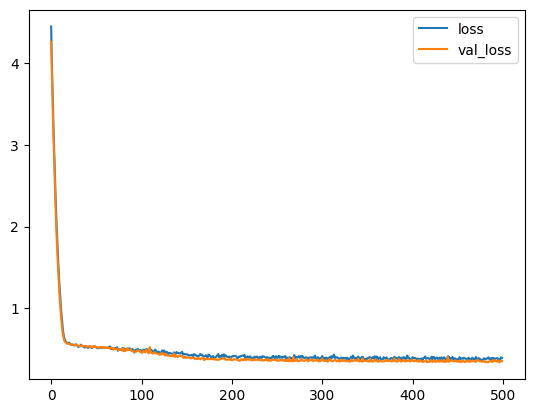

In [76]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

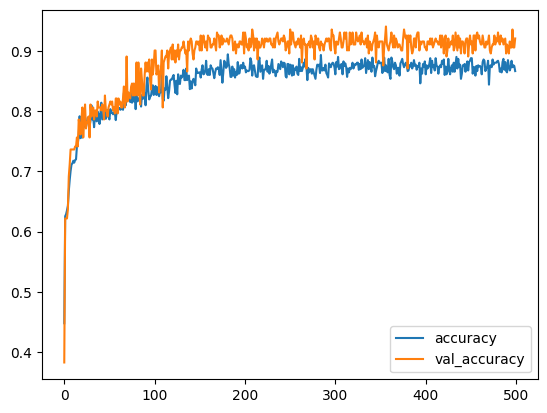

In [77]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [78]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.32525402307510376, 0.9104477763175964]

Train data evaluation:
[0.3307574987411499, 0.9122994542121887]


In [79]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

7/7 [==============================] - 0s 2ms/step


<Axes: >

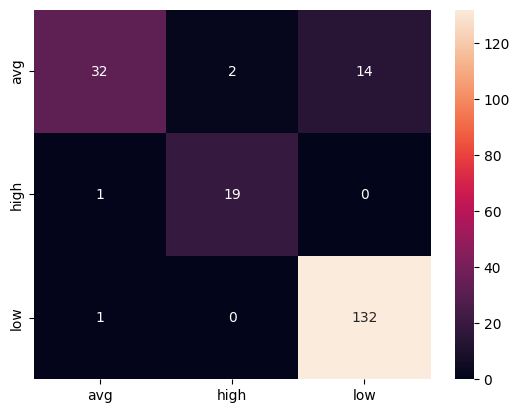

In [80]:
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [81]:
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

         avg       0.94      0.67      0.78        48
        high       0.90      0.95      0.93        20
         low       0.90      0.99      0.95       133

    accuracy                           0.91       201
   macro avg       0.92      0.87      0.88       201
weighted avg       0.91      0.91      0.90       201


Model overall accuracy: 91.04%


In [82]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

42/42 [==============================] - 0s 2ms/step


0.9349933826151119

In [83]:
tester_row = {
    'age': 40,
    'sex': 1,
    'bmi': 30,
    'children': 1,
    'smoker': 0,
    'region_northeast': 0,
    'region_northwest': 0,
    'region_southeast': 1,
    'region_southwest': 0
}

tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted charges range: {result_text}")

1/1 [==============================] - 0s 138ms/step
[0.093 0.002 0.906]
2
Predicted charges range: low
